In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../fuzzy-torch') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module
sys.path.append('../../sne-lightcurves-synthetic') # or just install the module

In [2]:
from flamingchoripan.files import search_for_filedirs
from lchandler import C_ as C_

surveys_rootdir = '../../surveys-save/'
filedirs = search_for_filedirs(surveys_rootdir, fext=C_.EXT_SPLIT_LIGHTCURVE)

────────────────────────────────────────────────────────────────────────────────────────────────────
found filedirs: (../../surveys-save/)
(0) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=linear.splcds - 118.999[mbs]
(1) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=uniformprior.splcds - 128.792[mbs]
(2) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe.splcds - 6.286[mbs]
(3) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=curvefit.splcds - 125.594[mbs]
(4) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=bspline.splcds - 118.925[mbs]
(5) - ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=mcmc.splcds - 125.451[mbs]
────────────────────────────────────────────────────────────────────────────────────────────────────
filedirs after searching with filters: (../../surveys-save/)


In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.files import get_dict_from_filedir
from lchandler import C_ as C_

def load_lcdataset(filename):
    assert filename.split('.')[-1]==C_.EXT_SPLIT_LIGHTCURVE
    return load_pickle(filename)

filedir = '../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=mcmc.splcds'

filedict = get_dict_from_filedir(filedir)
root_folder = filedict['*rootdir*']
cfilename = filedict['*cfilename*']
survey = filedict['survey']
lcdataset = load_lcdataset(filedir)
print(lcdataset['raw'].keys())
print(lcdataset['raw'].get_random_lcobj(False).keys())
print(lcdataset)

> loading: ../../surveys-save/alerceZTFv7.1/survey=alerceZTFv7.1°bands=gr°mode=onlySNe°method=mcmc.splcds
dict_keys(['data', 'survey', 'description', 'band_names', 'class_names', 'obs_is_flux'])
dict_keys(['days', 'obs', 'obse', 'y', 'synthetic'])
LCDataset:
[outliers - samples 10]
(*) obs_samples: 541 - min_len: 14 - max_dur: 408.0[days] - dur(p50): 133.8[days] - cadence(p50): 1.0[days]
(g) obs_samples: 260 - min_len: 6 - max_dur: 408.0[days] - dur(p50): 133.7[days] - cadence(p50): 3.0[days]
(r) obs_samples: 281 - min_len: 8 - max_dur: 376.0[days] - dur(p50): 128.7[days] - cadence(p50): 3.0[days]
   |█▌      | SLSN - 2/10 (20.00%)
   |▊       | SNIa - 1/10 (10.00%)
   |█▌      | SNIbc - 2/10 (20.00%)
   |████    | allSNII - 5/10 (50.00%)
────────────────────────────────────────────────────────────────────────────────────────────────────
[faint - samples 44]
(*) obs_samples: 990 - min_len: 7 - max_dur: 298.1[days] - dur(p50): 40.0[days] - cadence(p50): 1.0[days]
(g) obs_samples: 409 - 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


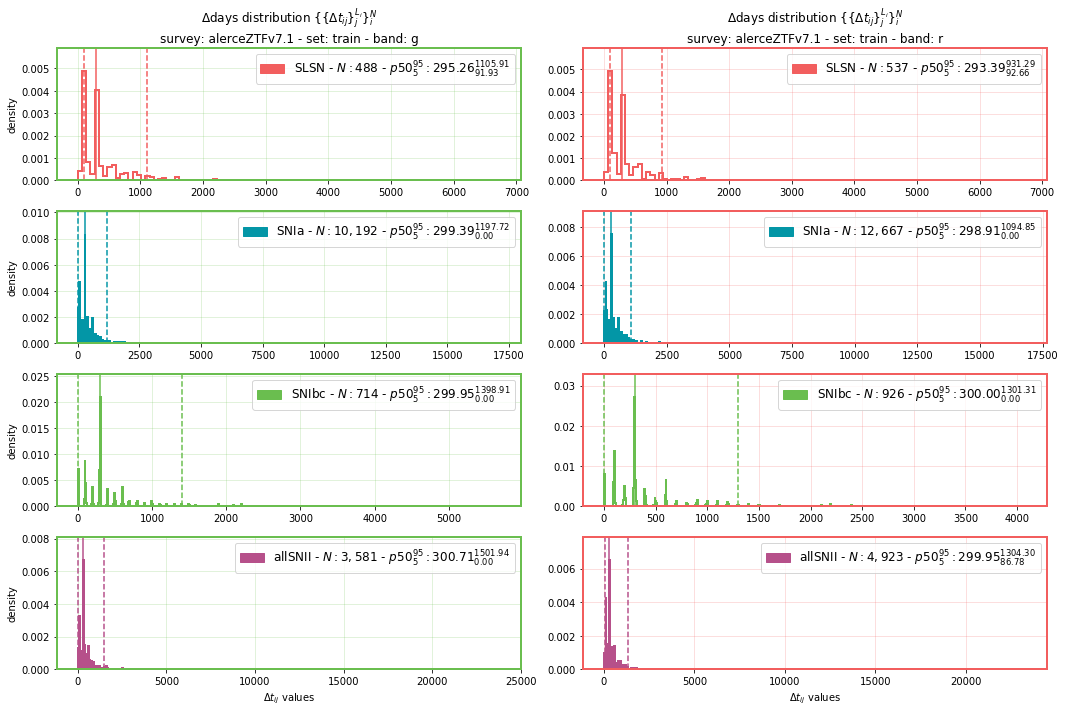

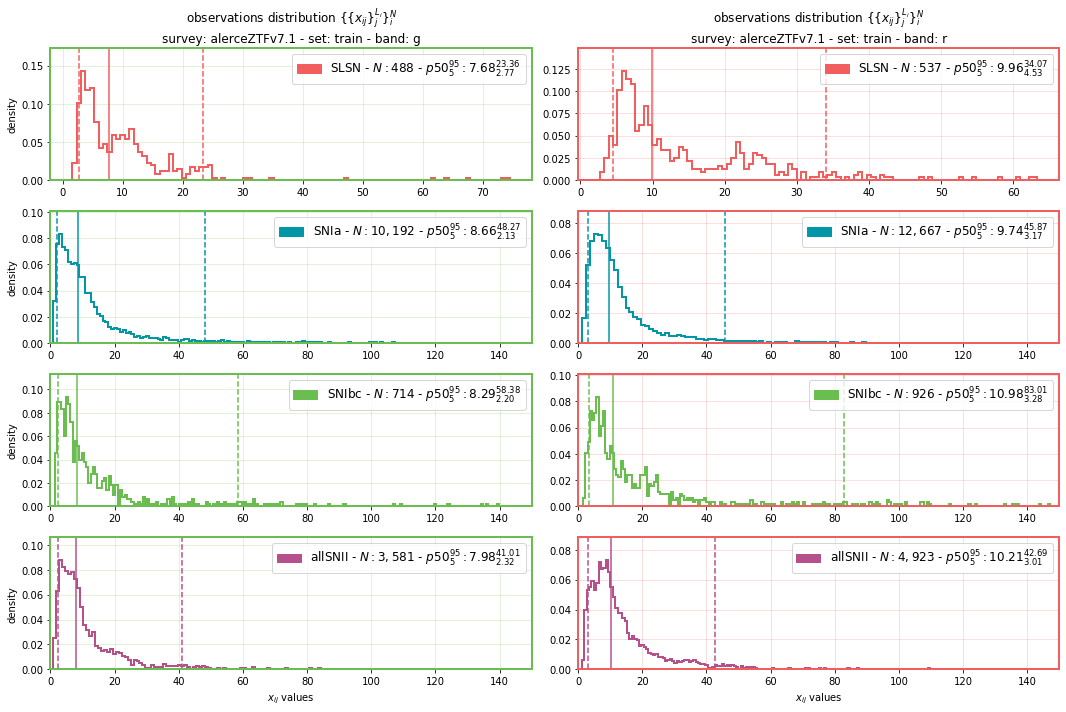

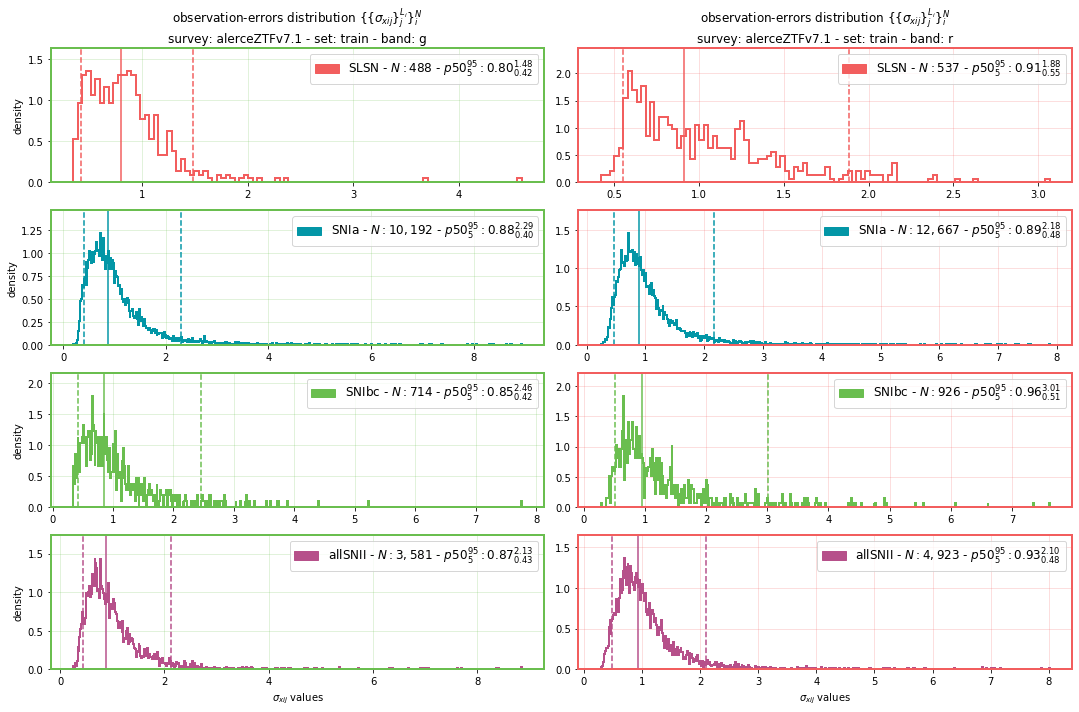

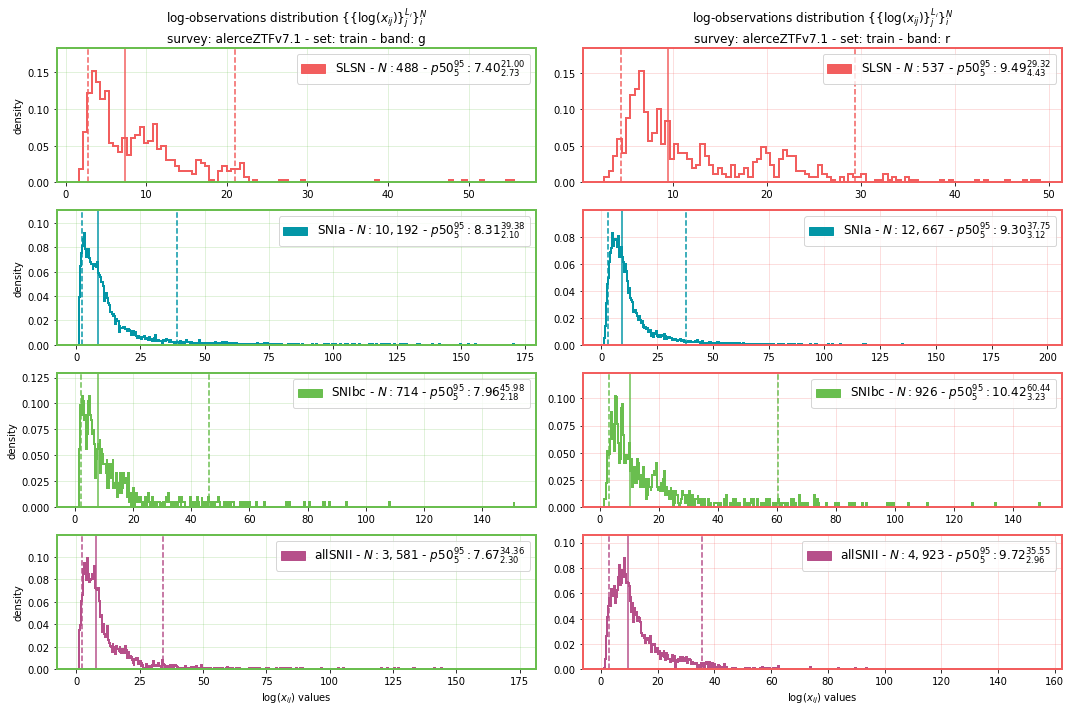

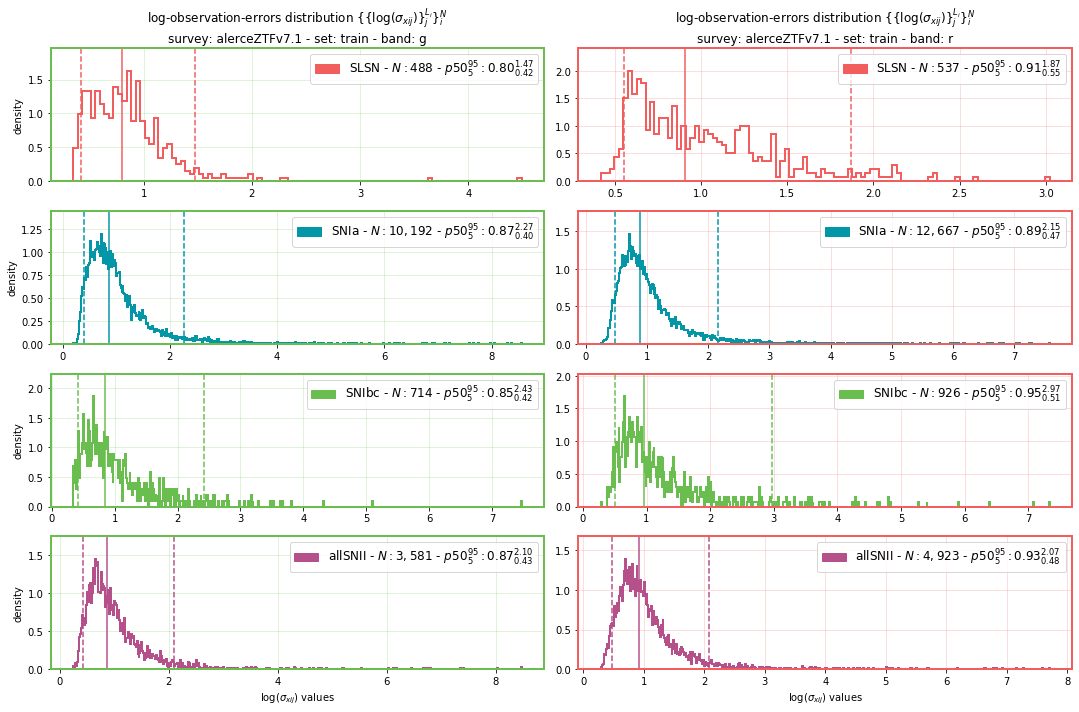

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from lchandler.plots.distrs import plot_values_distribution

set_name = 'train'
#set_name = 'synth_train'
lcdataset[set_name].set_diff_parallel('days')
lcdataset[set_name].set_log_parallel('obs')
lcdataset[set_name].set_log_parallel('obse')
plot_values_distribution(lcdataset, set_name, 'd_days')
plot_values_distribution(lcdataset, set_name, 'obs')
plot_values_distribution(lcdataset, set_name, 'obse')
plot_values_distribution(lcdataset, set_name, 'log_obs')
plot_values_distribution(lcdataset, set_name, 'log_obse')

In [5]:
%load_ext autoreload
%autoreload 2
from lcclassifier.datasets import CustomDataset

dataset_kwargs = {
    #'attrs':['days','obs', 'obse'],
    'attrs':['log_obs', 'log_obse'],
    #'attrs':['d_days','log_obs', 'log_obse'],
    'max_day':150.,
    #'te_features':0,
    'te_features':4,
}
r_train_dataset = CustomDataset(lcdataset, 'train', **dataset_kwargs)
r_val_dataset = CustomDataset(lcdataset, 'val', **dataset_kwargs)
r_train_dataset.transfer_to(r_val_dataset) # transfer information to val/test
print('r_train_dataset:', r_train_dataset)
print('r_val_dataset:', r_val_dataset)

s_train_dataset = CustomDataset(lcdataset, 'train+val.mcmc', **dataset_kwargs)
print('s_train_dataset:', s_train_dataset)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
r_train_dataset: CustomDataset(lcset_len=1,242, max_day=150.00, max_len=169, te_periods=[300.0, 150.0], attrs=['log_obs', 'log_obse'], norm_bdict={'g': StandardScaler(), 'r': StandardScaler()}, poblation_weights={'SLSN': 0.7626627457910646, 'SNIa': 0.011286764209627785, 'SNIbc': 0.17795464068458175, 'allSNII': 0.04809584931472583})
r_val_dataset: CustomDataset(lcset_len=309, max_day=150.00, max_len=169, te_periods=[300.0, 150.0], attrs=['log_obs', 'log_obse'], norm_bdict={'g': StandardScaler(), 'r': StandardScaler()}, poblation_weights={'SLSN': 0.7891057206380307, 'SNIa': 0.010031005017743204, 'SNIbc': 0.15782114412760614, 'allSNII': 0.04304213021661986})
s_train_dataset: CustomDataset(lcset_len=100,175, max_day=150.00, max_len=169, te_periods=[300.0, 150.0], attrs=['log_obs', 'log_obse'], norm_bdict={'g': StandardScaler(), 'r': StandardScaler()}, poblation_weights={'SLSN': 0.7658423361457566, 'SNIa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


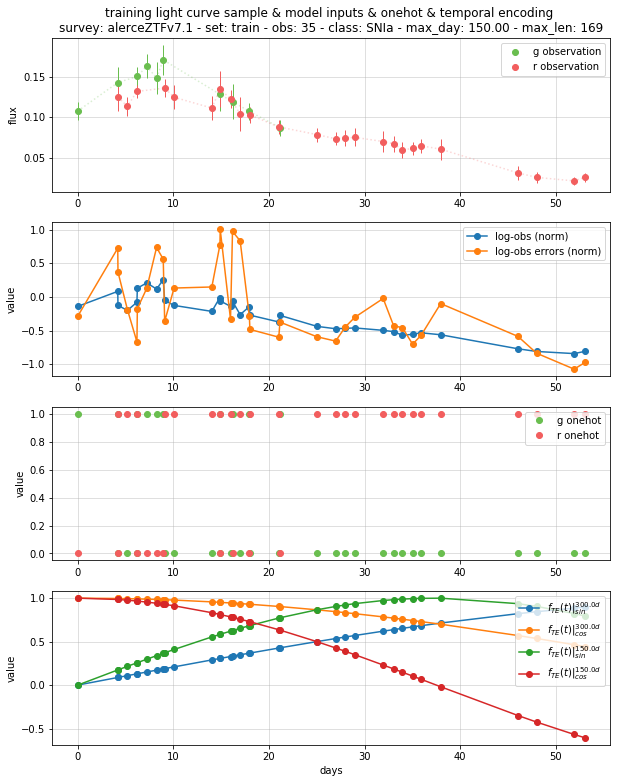

In [9]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from lchandler.plots.lc import plot_lightcurve
from lchandler import C_ as C_
%matplotlib inline

dataset = s_train_dataset
dataset = r_train_dataset
lcobj_name = dataset.get_random_stratified_lcobj_names()[0]
tdict, lcobj = dataset.get_item(lcobj_name, uses_len_clip=False, uses_daugm=False, return_lcobjs=True)
model_input = tdict['input']
target = tdict['target']
len_lcobj = model_input['onehot'].sum()

figsize = (10,13)
fig, axs = plt.subplots(4, 1, figsize=figsize)

ax = axs[0]
for kb,b in enumerate(lcobj.bands):
    plot_lightcurve(ax, lcobj, b, label=f'{b} observation', max_day=dataset.max_day)
ax.set_ylabel('flux')
for kb,b in enumerate(lcobj.bands):
    #tmax = target[f'tmax.{b}']
    #label = f'{b} pm tmax - {tmax:.1f}[days]'
    #axs[0].axvline(tmax, ls='-', c=C_.COLOR_DICT[b], label=label)
    pass

ax = axs[1]
days = model_input['time'][...,0]
for ka,attr in enumerate(dataset.attrs):
    ax.plot(days[:len_lcobj], model_input['x'][:len_lcobj,ka], '-o', label=f'{C_.SHORT_NAME_DICT[attr]} (norm)')
ax.set_ylabel('value')

ax = axs[2]
for kb,b in enumerate(lcobj.bands):
    ax.plot(days[:len_lcobj], model_input['onehot'][:len_lcobj,kb], 'o', c=C_.COLOR_DICT[b], label=f'{b} onehot')
ax.set_ylabel('value')

ax = axs[3]
for kt in range(dataset.get_te_features_dims()):
    #label = '$TE^{('+str(kt)+')}$'+f' - {dataset.te_periods[kt//2]:.1f}[days]'
    te_text = 'sin' if kt%2==0 else 'cos'
    label = '$f_{TE}(t)|^{'+f'{dataset.te_periods[kt//2]:.1f}'+'d}_{'+te_text+'}$'
    ax.plot(days[:len_lcobj], model_input['te'][:len_lcobj,kt], '-o', label=label)
    if kt>4:
        break
ax.set_ylabel('value')

class_name = dataset.class_names[target['y']]
title = f'training light curve sample & model inputs & onehot & temporal encoding \n'
title += f'survey: {dataset.lcset.survey} - set: {dataset.set_name}'
title += f' - obs: {len_lcobj} - class: {class_name} - max_day: {dataset.max_day:.2f} - max_len: {dataset.max_len}'
#title += f' - training: {dataset.training}'
for ax in axs:
    #ax.legend(prop={'size':14})
    ax.legend(loc='upper right')
    ax.grid(alpha=0.5)
axs[0].set_title(title)
axs[-1].set_xlabel('days')
plt.show()

In [36]:
%load_ext autoreload
%autoreload 2
from lcclassifier.dataloaders import CustomDataLoader
from fuzzytorch.utils import print_tdict

loader_kwargs = {
    'batch_size':1,
    #'num_workers':1, # bug?
}
s_train_loader = CustomDataLoader(s_train_dataset, shuffle=True, uses_random_subcrops=1, **loader_kwargs)

for k,tdict in enumerate(s_train_loader):
    model_input = tdict['input']
    target = tdict['target']
    for idx in range(len(model_input['x'])):
        print_tdict(tdict)
        print(model_input['x'][idx,:,0])
        print(model_input['onehot'][idx].sum(-1))
    assert 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
26 [26, 6]
{input: {onehot: (2, 169, 2)-bool-cpu, x: (2, 169, 2)-float32-cpu, time: (2, 169, 1)-float32-cpu, error: (2, 169, 1)-float32-cpu, te: (2, 169, 4)-float32-cpu}, target: {y: (2)-int64-cpu, poblation_weights: (2, 4)-float32-cpu, raw-x: (2, 169, 1)-float32-cpu}}
tensor([ 1.2010, -0.0783,  1.1188,  0.0081,  1.1705,  0.1647,  1.3410,  1.3549,
         0.7515,  1.0115,  0.6562,  0.5330,  0.3090,  0.1468, -0.0650,  0.0739,
        -0.2555, -0.4050, -0.0245, -0.2184, -0.5339, -0.2329, -0.6065, -0.6828,
        -0.4196, -0.6119,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
  

AssertionError: 